## エージェントの設計

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

MAX_FILENAME_LENGTH = 100     # 入力ファイル名上限
FILENAME_INPUT = "input.csv" 
FILENAME_OUTPUT = "output.csv"

# 設定パラメータ
NUM_AGENTS = 10000              # エージェント数
SIMU_YEAR_TERM = 50             # 検証する期間（年）
MARRIGE_AGE_MIN = 15            # 結婚可能下限年齢
MARRIGE_AGE_MAX = 45            # 結婚可能上限年齢
MARRIGE_TIMES_MAX = 10          # 結婚可能回数
DEATH_RATE = 0.00               # 死亡率

# 制御パラメータ
MARRIGE_PAIR_MAX_MAN = 1        # 男の同時結婚可能上限数
MARRIGE_PAIR_MAX_WOMAN = 1      # 女の同時結婚可能上限数
ENCOUNTER_COUNT = 10            # 遭遇する異性の数
BURDEN_TAX = 0.4                # 負担率（税・社会保険料など）
BURDEM_EDUCATION = 0.2          # 負担率（教育費）
BURDEN_RENT = 0.01              # 負担率（家賃）
INCOME_THRESHOLD = 300          # 結婚する最低限の所得 

class Agent:
    def __init__(self):
        self.partner_man = [0] * MARRIGE_PAIR_MAX_MAN     # 男性パートナー固有番号（構造体配列添字）
        self.partner_woman = [0] * MARRIGE_PAIR_MAX_WOMAN # 女性パートナー固有番号（構造体配列添字）
        self.age_marriage = [0] * MARRIGE_TIMES_MAX       # 結婚した年齢
        self.age_divorce = [0] * MARRIGE_TIMES_MAX        # 離婚した年齢
        
        self.married_check = 0                            # 既婚1 独身0
        self.life = 1                                     # 生1 死0
        self.gender = random.choice([0, 1])               # 性別 女1 男0
        self.age = random.randint(16, 45)                 # 年齢 16~45

        self.edu_level = 1                                # 教育レベル。 高校卒　短大卒　大卒（１〜３）
        self.occupation = 1                               # 業種　第n次産業（１〜３）
        self.income = 0.0                                 # 可処分の月収（性別と教育レベルから分布）
        self.tax = 0.0                                    # 税・社会保険料（独身かどうかでも変わる）
        self.rate_hours_work = 0.0                        # 労働時間率
        self.rate_hours_housework = 0.0                   # 家事時間率
        self.rate_hours_childcare = 0.0                   # 育児時間率
        self.cost_childcare = 0.0                         # 育児コスト
        self.times_marriage = 0                           # 結婚回数
        self.cost_marriage = 0.0                          # 結婚コスト
        self.rate_marriage = 0.0                          # 成婚率（男女で計算式が異なりそう）
        self.rate_divorce = 0.0                           # 離婚率（人口統計から世帯収入別の？年別離婚率を採用）




## 仮定する成婚率パラメータ分布の設計

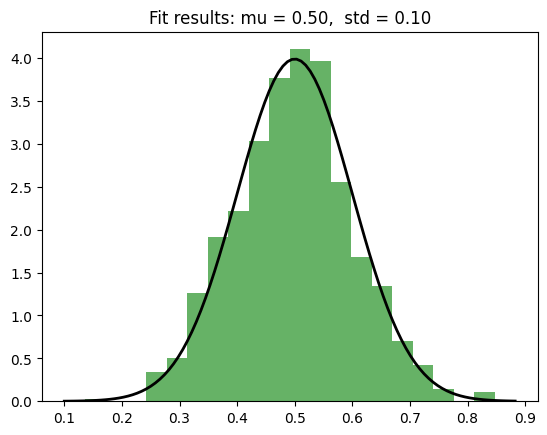

In [2]:

import numpy as np
import matplotlib.pyplot as plt

# パラメータ設定
mean_value = 0.5  # 平均値
std_dev = 0.1     # 標準偏差
num_samples = 1000 # サンプル数

# 正規分布に従うランダムな値を生成
samples = np.random.normal(mean_value, std_dev, num_samples)

# ヒストグラムをプロット
plt.hist(samples, bins=20, density=True, alpha=0.6, color='g')

# 理論上の正規分布をプロット
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = np.exp(-0.5 * ((x - mean_value) / std_dev) ** 2) / (std_dev * np.sqrt(2 * np.pi))
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mean_value, std_dev)
plt.title(title)

plt.show()



## 表形式データ分布からサンプル生成

    year  birth_rate  marriage_rate  divorce_rate   tfr  wfmf_rate  wrmr_rate  \
0   1947        34.3           12.0          1.02  4.54        NaN        NaN   
1   1948        33.5           11.9          0.99  4.40        NaN        NaN   
2   1949        33.0           10.3          1.01  4.32        NaN        NaN   
3   1950        28.1            8.6          1.01  3.65        NaN        NaN   
4   1951        25.3            7.9          0.97  3.26        NaN        NaN   
..   ...         ...            ...           ...   ...        ...        ...   
72  2019         7.0            4.8          1.69  1.36       73.3        9.9   
73  2020         6.8            4.3          1.57  1.33       73.6        9.8   
74  2021         6.6            4.1          1.50  1.30       74.0        9.8   
75  2022         6.3            4.1          1.47  1.26       74.8        9.4   
76  2023         6.0            3.9          1.52  1.20        NaN        NaN   

    wfmr_rate  wrmf_rate  


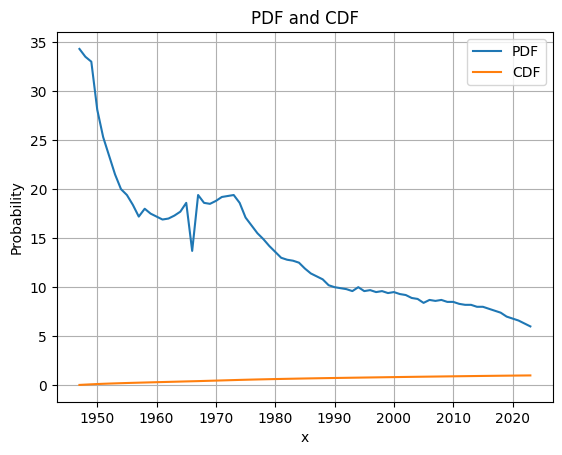

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# CSVファイルのパスを指定
file_path = './data/year/distr_rate_year_lifeevent.csv'

# CSVファイルをデータフレームに読み込む
df = pd.read_csv(file_path, header=2)

# データフレームを表示
print(df)

def pdf_to_cdf(x_values, pdf_values):
    """
    PDFからCDFを計算する関数。

    Parameters:
    x_values (numpy.ndarray): x軸の値。
    pdf_values (numpy.ndarray): 確率密度関数の値。

    Returns:
    numpy.ndarray: 累積分布関数の値。
    """
    # CDFの初期化
    cdf_values = np.zeros_like(pdf_values)

    # 台形則を使ってCDFを計算
    cdf_values[0] = pdf_values[0]  # 最初の値はそのままコピー
    for i in range(1, len(pdf_values)):
        cdf_values[i] = cdf_values[i-1] + (pdf_values[i-1] + pdf_values[i]) * (x_values[i] - x_values[i-1]) / 2

    # CDFの正規化（0から1の範囲にする）
    cdf_values /= cdf_values[-1]
    
    return cdf_values

# 表形式のPDFデータ (x, f(x))
x_values = df["year"].values
pdf_values = df["birth_rate"].values
cdf_values = pdf_to_cdf(x_values, pdf_values)

# 結果をプロット
plt.plot(x_values, pdf_values, label='PDF')
plt.plot(x_values, cdf_values, label='CDF')
plt.xlabel('x')
plt.ylabel('Probability')
plt.title('PDF and CDF')
plt.legend()
plt.grid(True)
plt.show()

## 経験データの分布確認

1


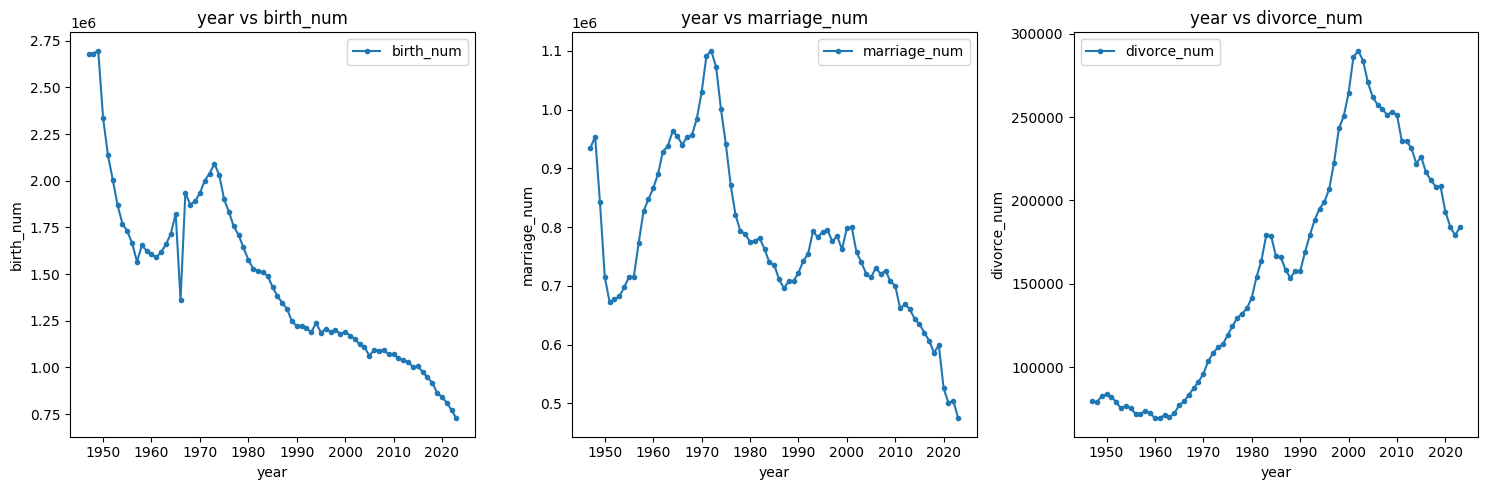

1


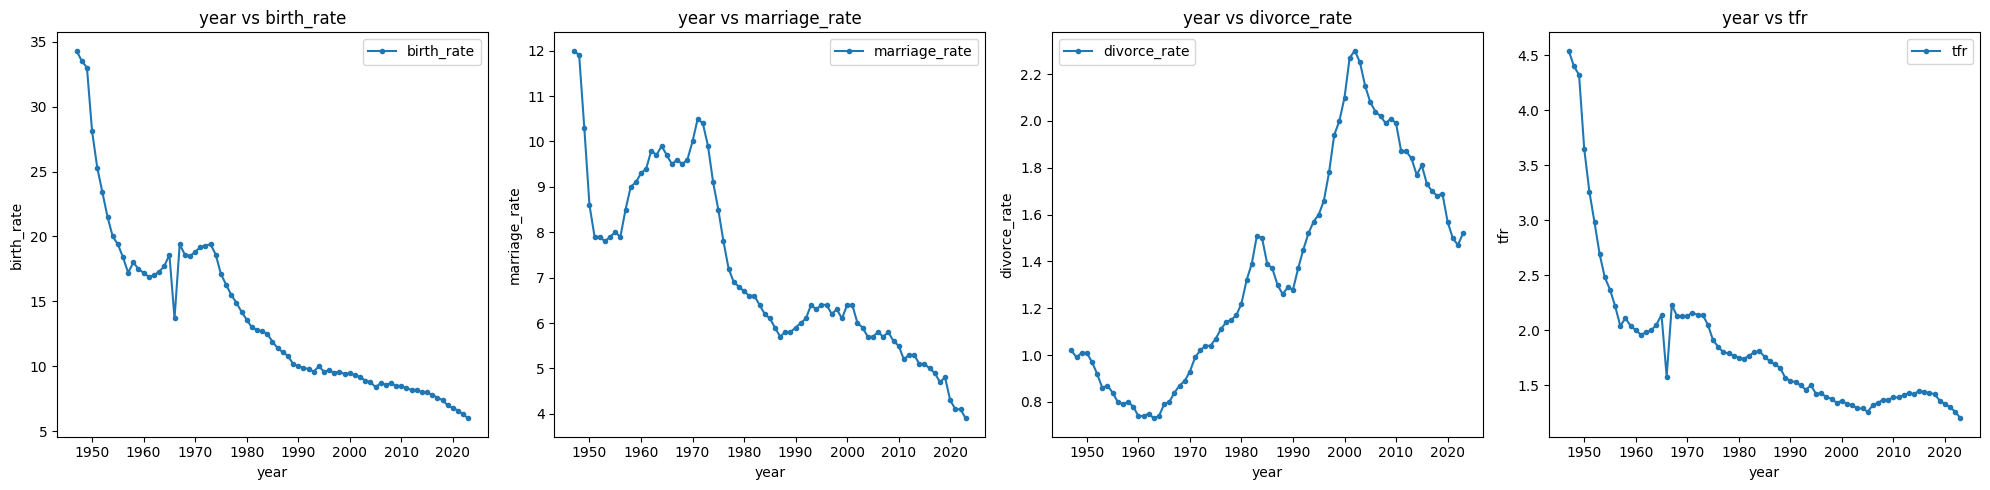

In [13]:
# グラフを横に描画する関数
def plot_line_graphs(df, x_col, y_cols):
    m_plots = len(y_cols)
    l_plots = m_plots // 5 + 1
    print(l_plots)
    plt.figure(figsize=(20, 5 * l_plots))

    for i, col in enumerate(y_cols):
        plt.subplot(l_plots, 4, i + 1)
        plt.plot(df[x_col], df[col], label=col, marker="o", markersize=3)
        plt.xlabel(x_col)
        plt.ylabel(col)
        plt.title(f'{x_col} vs {col}')
        plt.legend()

    plt.tight_layout()
    plt.show()

# CSVファイルをデータフレームに読み込む
df_num_year_lifeevent  = pd.read_csv("./data/year/distr_num_year_lifeevent.csv", header=1)
df_rate_year_lifeevent = pd.read_csv("./data/year/distr_rate_year_lifeevent.csv", header=2)

# 折れ線グラフを生成
plot_line_graphs(df_num_year_lifeevent,  "year", ["birth_num", "marriage_num", "divorce_num"])
plot_line_graphs(df_rate_year_lifeevent, "year", ["birth_rate", "marriage_rate", "divorce_rate", "tfr"])



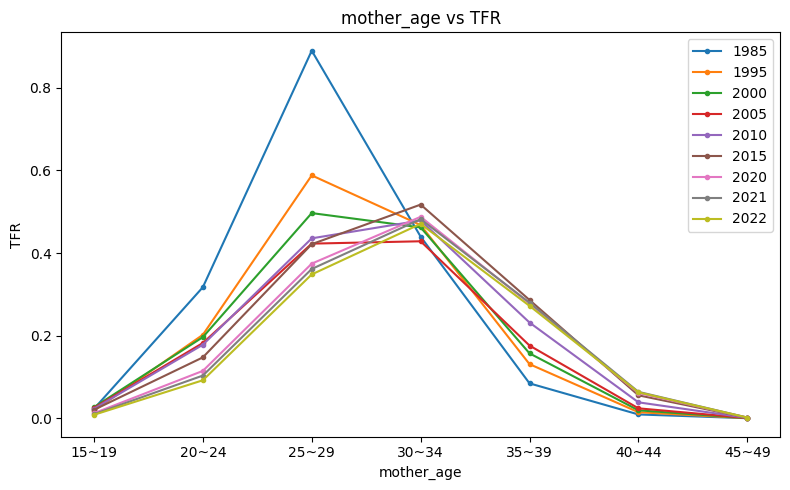

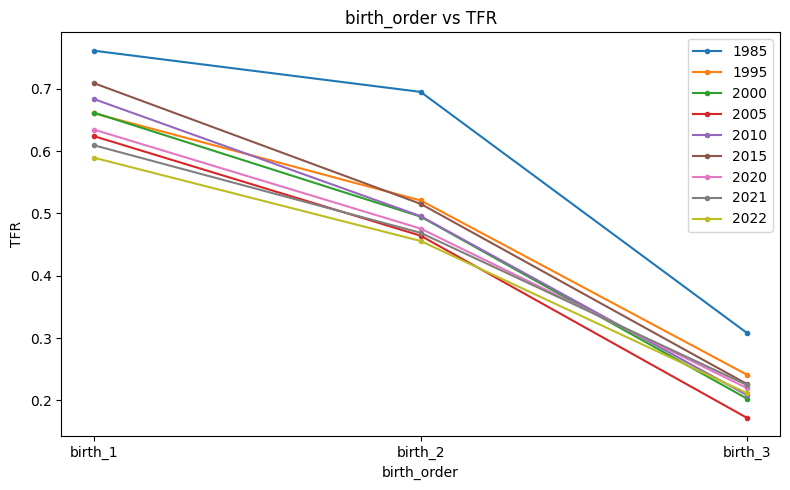

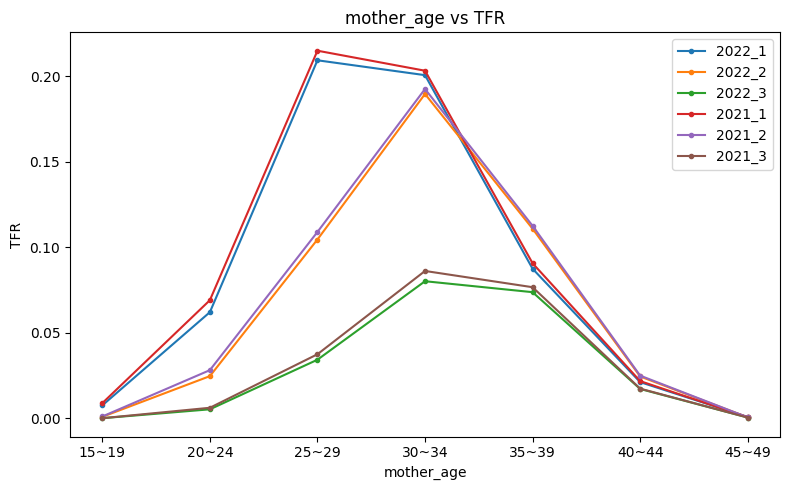

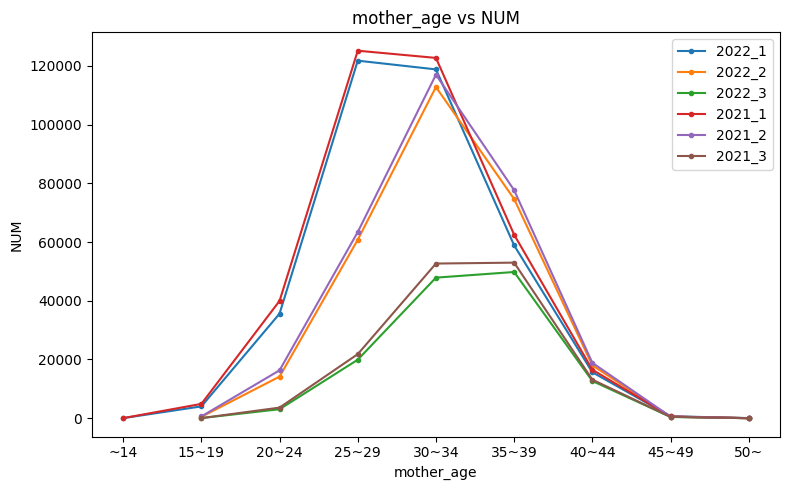

In [14]:
# グラフを重ねて描画する関数
def plot_line_graphs(df, y_label, x_col, y_cols):
    plt.figure(figsize=(8, 5))

    for i, col in enumerate(y_cols):
        plt.plot(df[x_col], df[col], label=col, marker="o", markersize=3)
    plt.xlabel(x_col)
    plt.ylabel(y_label)
    plt.title(f'{x_col} vs {y_label}')
    plt.legend()

    plt.tight_layout()
    plt.show()

df_tfr_cohort            = pd.read_csv("./data/birth/distr_tfr_cohort.csv", header=1)
df_tfr_birthorder        = pd.read_csv("./data/birth/distr_tfr_birthorder.csv", header=1)
df_tfr_birthorder_cohort = pd.read_csv("./data/birth/distr_tfr_birthorder_cohort.csv", header=1)
df_num_birthorder_cohort = pd.read_csv("./data/birth/distr_num_birthorder_cohort.csv", header=1)

df_tfr_cohort            = df_tfr_cohort.drop(0)
df_tfr_birthorder        = df_tfr_birthorder.drop(0)
df_tfr_birthorder_cohort = df_tfr_birthorder_cohort.drop(0)
df_num_birthorder_cohort = df_num_birthorder_cohort.drop(0)

plot_line_graphs(df_tfr_cohort, "TFR", "mother_age", ["1985", "1995", "2000", "2005", "2010", "2015", "2020","2021", "2022"])
plot_line_graphs(df_tfr_birthorder, "TFR", "birth_order", ["1985", "1995", "2000", "2005", "2010", "2015", "2020","2021", "2022"])
plot_line_graphs(df_tfr_birthorder_cohort, "TFR", "mother_age", ["2022_1", "2022_2", "2022_3", "2021_1", "2021_2", "2021_3"])
plot_line_graphs(df_num_birthorder_cohort, "NUM", "mother_age", ["2022_1", "2022_2", "2022_3", "2021_1", "2021_2", "2021_3"])

## エージェントのパラメータ分布の確認


[31, 39, 18, 28, 38, 17, 17, 32, 28, 21]


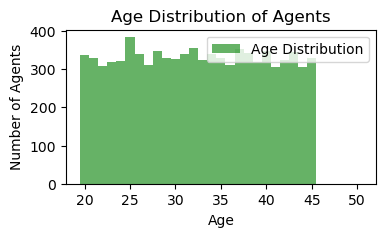

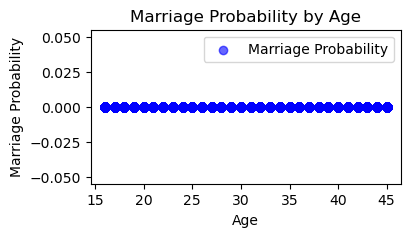

In [37]:
agents = [Agent() for _ in range(NUM_AGENTS)]

# 年齢が30歳以上のエージェントのインデックスを取得

# 各エージェントのパラメータを一つのリストとして参照
ages = [agent.age for agent in agents]
#indices_30_or_more = [i for i, agent in enumerate(agents) if agent.age >= 30]

# 結果を表示
print(ages[:10])  # 最初の10エージェントの年齢を表示

# 正規分布のパラメータ（平均と標準偏差を仮定）
mean_age = 0.5
std_dev_age = 0.2

# 各年齢に対する結婚の確率を正規分布に基づいて計算
marriage_probabilities = norm.pdf(ages, mean_age, std_dev_age)

# 結果の可視化
plt.figure(figsize=(4,2))
plt.hist(ages, bins=np.arange(20, 52) - 0.5, alpha=0.6, color='g', label='Age Distribution')
plt.xlabel('Age')
plt.ylabel('Number of Agents')
plt.title('Age Distribution of Agents')
plt.legend()
plt.show()

plt.figure(figsize=(4,2))
plt.scatter(ages, marriage_probabilities, alpha=0.6, color='b', label='Marriage Probability')
plt.xlabel('Age')
plt.ylabel('Marriage Probability')
plt.title('Marriage Probability by Age')
plt.legend()
plt.show()




## シミュレーション